In [1]:
# !pip install Unidecode

# Connect to NCBO annotator

In [2]:
import urllib.request, urllib.error, urllib.parse
import matplotlib.pyplot as plt
import pandas as pd 
import json
import os

from dotenv import load_dotenv
from unidecode import unidecode
from collections import defaultdict
from brat_parser import get_entities_relations_attributes_groups

### Load API Key and variables 

In [3]:
load_dotenv()

API_KEY = os.getenv('API_KEY')
REST_URL = os.getenv('REST_URL')

### Read recipes and annotations 

In [4]:
def get_json(url):
    opener = urllib.request.build_opener()
    opener.addheaders = [('Authorization', 'apikey token=' + API_KEY)]
    return json.loads(opener.open(url).read())

In [5]:
def get_recipe_annotation(recipe):
    result = defaultdict(list)
    
    for line in recipe.split('\n'):
        line = unidecode(line).replace('%', '%25')
        annotations = get_json(REST_URL + "/annotator?text=" + line.replace(" ", "+") + 
                               "&ontologies=FOODON&roots_only=true&exclude_synonyms=true&include=prefLabel")
        
        for elem in annotations: 
            # if "FOODON" in elem["annotatedClass"]["links"]["ontology"].split('/')[-1]:
            # print(elem["annotatedClass"]["links"]["ontology"], elem["annotatedClass"]["@id"])
            result[elem["annotatedClass"]["prefLabel"]] = elem["annotatedClass"]["@id"] # elem['annotations']
                
    return result

In [6]:
def read_recipe(file_name):
    with open(file_name, encoding="utf8") as f:
        return f.read().splitlines()

In [7]:
def read_mannual_annotations(file_name): 
    result = dict()
    
    entities, _, _, _ = get_entities_relations_attributes_groups(file_name)
        
    for elem in entities.values():
        result[elem.text] = elem.type
                
    return result

In [8]:
recipes = []
manual_annotations = []
all_ncbo_results = []


for i in range(10):
    recipe = read_recipe('./0-1-2/' + str(i) + '.txt')
    recipes.append(recipe)
    manual_annotations.append(read_mannual_annotations('./0-1-2/' + str(i) + '.ann'))

    ncbo_results = []
    for line in recipe:
        ann = get_recipe_annotation(line)
        ncbo_results.append(ann)
    
    all_ncbo_results.append(ncbo_results)

### Experiments - compare results 

#### 1. How many entities have been recognized in NCBO and mannual? 

In [9]:
counter = 0
ncbo_elements = 0

all_keys = []
for elem in manual_annotations:
    all_keys += list(elem.keys())

for ncbo_result in all_ncbo_results:
    for elem in ncbo_result:
        for key in elem:
            ncbo_elements += 1
            
            if key in all_keys:
                counter +=1
            # else:
                # print(key)

print('Entities which is in both methods:', counter)

Entities which is in both methods: 42


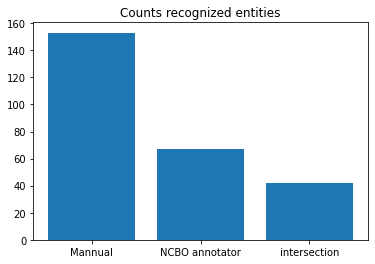

In [10]:
fig = plt.figure()

labels = ['Mannual', 'NCBO annotator', 'intersection']
values = [len(all_keys), ncbo_elements, counter]

plt.bar(labels, values)

plt.title("Counts recognized entities")
plt.show()

#### 2. Percent recognized by class

In [11]:
counter_by_class = defaultdict(int)
manual_counter = defaultdict(int)
part_counter = defaultdict(int)

for i, manual_annotation in enumerate(manual_annotations):
    for key, class_value in manual_annotation.items(): 
        manual_counter[class_value] += 1
        # print(i, key, class_value, all_ncbo_results[i])
        for elem in all_ncbo_results[i]:
            if key in elem.keys():
                counter_by_class[class_value] += 1
            for ncbo_key in elem.keys():
                if key in ncbo_key.split() and key != ncbo_key:
                    # print(key, ncbo_key)
                    part_counter[class_value] += 1

In [12]:
pd_counter_by_class = pd.DataFrame.from_dict(manual_counter.items())

pd_counter_by_class.columns = ['Class name', 'Manual Value']
pd_counter_by_class['NCBO Value'] = pd_counter_by_class['Class name'].map(counter_by_class)
pd_counter_by_class['Recognized (%)'] = pd_counter_by_class['NCBO Value'] / pd_counter_by_class['Manual Value'] * 100
pd_counter_by_class['Part NCBO Value'] = pd_counter_by_class['Class name'].map(part_counter)

pd_counter_by_class = pd_counter_by_class[['Class name', 'NCBO Value', 'Manual Value', 'Recognized (%)', 'Part NCBO Value']]
pd.options.display.float_format = '{:,.2f}'.format

display(pd_counter_by_class.sort_values(by=['Recognized (%)', 'NCBO Value', 'Manual Value'], 
                                        ascending=False).reset_index(drop=True))

,Class name,NCBO Value,Manual Value,Recognized (%),Part NCBO Value
0,color,3,3,100.00,2
1,food_product_with_unit,28,42,66.67,3
2,unit,6,29,20.69,0
3,food_product_without_unit_uncountable,1,6,16.67,2
4,quantity,0,37,0.00,0
5,process,0,13,0.00,1
6,food_product_without_unit_countable,0,10,0.00,1
7,physical_quality,0,6,0.00,0
8,trade_name,0,3,0.00,0
9,part,0,1,0.00,0


In [13]:
percent_result = [{elem: str(counter_by_class[elem]/counter * 100) + '%'} for elem in counter_by_class if counter_by_class[elem] > 0 ]
display(percent_result)

[{'food_product_with_unit': '66.66666666666666%'},
 {'unit': '14.285714285714285%'},
 {'food_product_without_unit_uncountable': '2.380952380952381%'},
 {'color': '7.142857142857142%'}]

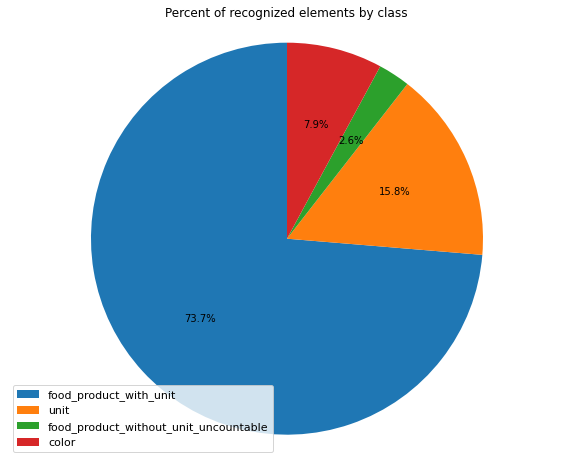

In [14]:
fig1, ax1 = plt.subplots(figsize=(10, 8))

counter_by_class_to_plot = {k: v for k, v in counter_by_class.items() if v > 0}

ax1.pie(counter_by_class_to_plot.values(), autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Percent of recognized elements by class')
plt.legend(labels=counter_by_class_to_plot.keys(),  prop={'size': 11}, loc='lower left')
plt.show()

#### 3. Is the context valuable? 

##### 3.1 Is this always recognized? 

In [15]:
# False is only for 'ice' in 'juice' so I think is bad example - with old link
# Now it's about plural - f.e. "teaspoon" (key) is in "teaspoons" (recipe) but hasn't got annotations (based on recipe)
interesting_context = defaultdict(lambda: defaultdict(int))


for index, annotations in enumerate(all_ncbo_results):
    for elem in annotations:
        keys = elem.keys()
        
        for key in keys:
            for i, recipe in enumerate(recipes):
                if i != index:
                    ncbo_ann = all_ncbo_results[i]

                    for j, line in enumerate(recipe):
                        if ' ' + key in line or line.startswith(key + ' '):
                            interesting_context[key]['Total'] += 1
                            
                            if key in ncbo_ann[j].keys():
                                interesting_context[key]['True'] += 1
                            else:
                                # print(key, line, ncbo_ann[j])
                                interesting_context[key]['False'] += 1


interesting_context_pd = pd.DataFrame.from_dict(interesting_context, orient='index')
interesting_context_pd['Percent'] = (interesting_context_pd['True'] / interesting_context_pd['Total'] * 100).fillna(0)

display(interesting_context_pd.sort_values(by=['Percent', 'True'], ascending=False))

,Total,True,False,Percent
orange,6,6.00,NaN,100.00
milk,6,6.00,NaN,100.00
salt,6,6.00,NaN,100.00
cinnamon,4,4.00,NaN,100.00
sugar,4,4.00,NaN,100.00
orange juice,2,2.00,NaN,100.00
butter,2,2.00,NaN,100.00
chocolate,2,2.00,NaN,100.00
triple sec,1,1.00,NaN,100.00
teaspoon,31,16.00,15.00,51.61


##### 3.2 Is this always recognized  as the same class?

In [16]:
# False only in links like [] and .../UC_12313 not to FOODON ontology
interesting_context_links = defaultdict(lambda: defaultdict(int))

for index, annotations in enumerate(all_ncbo_results):
    for elem in annotations:
        keys = elem.keys()
        
        for key in keys:
            links = elem[key]
            
            for ind, inside_annotations in enumerate(all_ncbo_results):
                for inside_elem in inside_annotations:
                    inside_keys = inside_elem.keys()

                    for inside_key in inside_keys:
                        if key == inside_key:
                            inside_links = inside_elem[inside_key]
                            interesting_context_links[key]['Total'] += 1
                            
                            if links == inside_links:
                                interesting_context_links[key]['True'] += 1
                            else:
                                # print(links, inside_links)
                                interesting_context_links[key]['False'] += 1


interesting_context_links_pd = pd.DataFrame.from_dict(interesting_context_links, orient='index')
interesting_context_links_pd['Percent'] = interesting_context_links_pd['True'] / interesting_context_links_pd['Total'] * 100

display(interesting_context_links_pd.sort_values(by=['Percent', 'True'], ascending=False))

,Total,True,Percent
teaspoon,25,25,100.00
orange,9,9,100.00
cinnamon,9,9,100.00
milk,9,9,100.00
sugar,9,9,100.00
salt,9,9,100.00
triple sec,4,4,100.00
orange juice,4,4,100.00
butter,4,4,100.00
Vanilla,4,4,100.00


### Read all dataset

In [17]:
recipes = []
manual_annotations = []
all_ncbo_results = []

for i in range(300):
    print(i)
    recipe = read_recipe('./0-1-2/' + str(i) + '.txt')
    recipes.append(recipe)
    manual_annotations.append(read_mannual_annotations('./0-1-2/' + str(i) + '.ann'))

    ncbo_results = []
    for line in recipe:
        ann = get_recipe_annotation(line)
        ncbo_results.append(ann)
    
    all_ncbo_results.append(ncbo_results)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

#### 4. Tests on the *process* and *physical_quality* class

##### 4.1 Find labeled and unlabeled values

In [18]:
def get_labeled_by_class(class_name):
    class_labeled = set()
    class_unlabeled = set()


    for i, manual_annotation in enumerate(manual_annotations):
        for key, class_value in manual_annotation.items(): 
            if class_value == class_name:
                added = False
                for elem in all_ncbo_results[i]:
                    if key in elem.keys():
                        class_labeled.add(key)
                        # print(i)   # Uncomment to know in which recipes are recognized forms
                        added = True
                        break
                if not added:
                    class_unlabeled.add(key)
                        
    return class_labeled, class_unlabeled

In [19]:
process_labeled, process_unlabeled = get_labeled_by_class('process')

print('Labeled process:')
print(process_labeled)

print()

print('Unlabeled process:')
print(process_unlabeled)

Labeled process:
{'frozen', 'sliced'}

Unlabeled process:
{'washed', 'completely defrosted', 'cut into 4 wedges', 'refrigerated', 'popped', 'baked', 'boiled', 'finely minced', 'cut into thin strips', 'do NOT peel!', 'giblets and neck discarded', 'sliced lengthwise', 'roast', 'chopped', 'densely packed fresh', 'broken into bite sized pieces', 'divided in half', 'freshly squeezed', 'lightly beaten', 'freshly grated', 'mashed up', 'cut in half diagonally', 'pitted', 'zested', 'warmed', 'grated', 'undrained', 'broken in half', 'cut into 1/2-inch strips', 'each cut into 6 wedges', 'halved', 'cut into 1.5 inch cubes', 'cut about 4 inches thick', 'choppped', 'peeled', 'cut into 2 inch chunks', 'roasted', 'cut into thin slivers', 'cut into bite-sized chunks', 'prepared cold', 'remove stems', 'shredded', 'thawed', 'sliced thin across the grain', 'cooled to room temperature', 'scrubbed well', 'split', 'unwrapped', 'torn into pieces', 'ground', 'cut', 'filtered', 'crushed', 'thinly flattened', 'c

In [20]:
physical_quality_labeled, physical_quality_unlabeled = get_labeled_by_class('physical_quality')

print('Labeled process:')
print(physical_quality_labeled)

print()

print('Unlabeled process:')
print(physical_quality_unlabeled)

Labeled process:
{'half and half', 'whole grain', 'full cream', 'frozen', 'soft', 'plain'}

Unlabeled process:
{'skinless', 'refrigerated', 'packed', 'solid', 'pure', 'room temperature', 'reduced fat', 'unpeeled', 'instant', 'unbaked', 'dry', 'uncooked', 'cake icing', 'chunky', 'full-fat', 'not braided', 'small floury', 'organic', 'large head', 'whole whea', 'cubes', 'extra virgin', '16 in (40 cm) long 5 in (12 cm) wide', 'pitted', 'Reduced Fat', 'cold', 'smooth', 'mnce', 'Sliced', 'low-fat', 'Smoked', '3/4-inch thick', 'thick', 'melting', 'roasted', 'canned', 'miniature', 'baby', 'ready minced', 'superfine', 'real', 'fresh', 'ground', 'refrigerated until used', 'crushed', 'boiling', 'good quality', 'natural', 'disk', 'extra-virgin', 'powdered', 'fettuccine', 'oval', 'large or extra large', 'medium', 'coarse', 'at cool room temperature', 'frozen precooked', 'ripened', 'dried', 'not instant', '1/2 inch (1 1/4 cm) thick', 'no-salt-added', 'big', 'bone-in', 'small star shapes', 'thin', 's

#####  4.2 Find match class for labeled data and manual one

Class matched *frozen* 

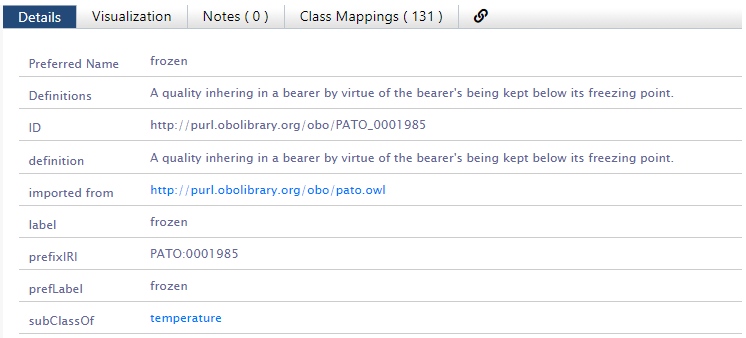

Class not matched *food (frozen)* 

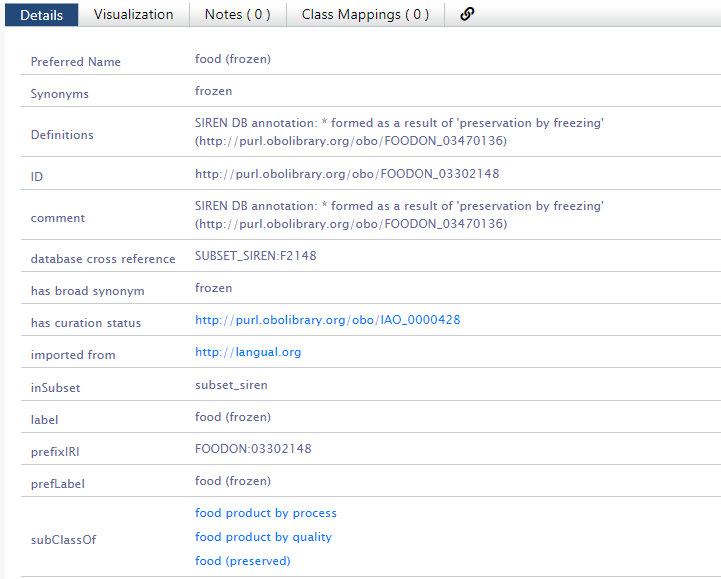

Class matched *sliced*

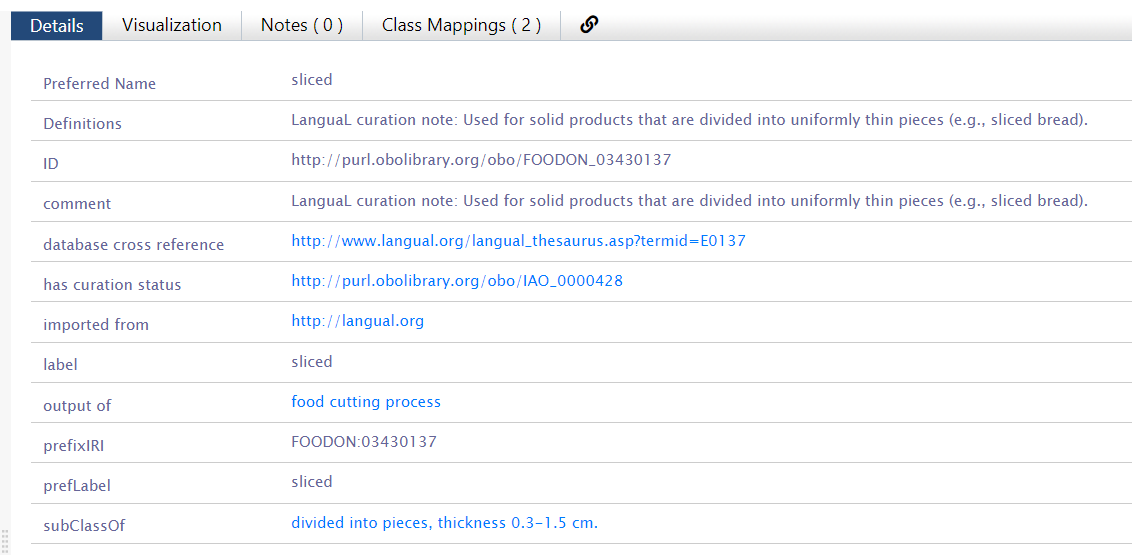

Class description *food cutting process*

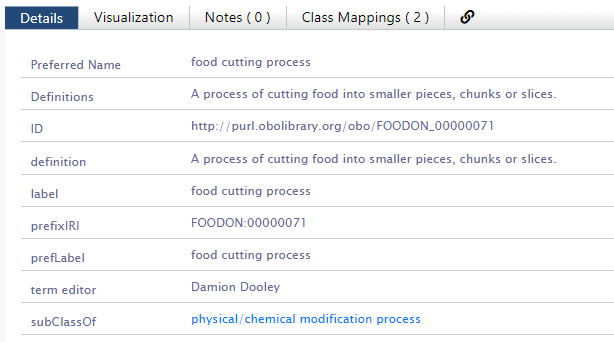

Class matched *half and half*

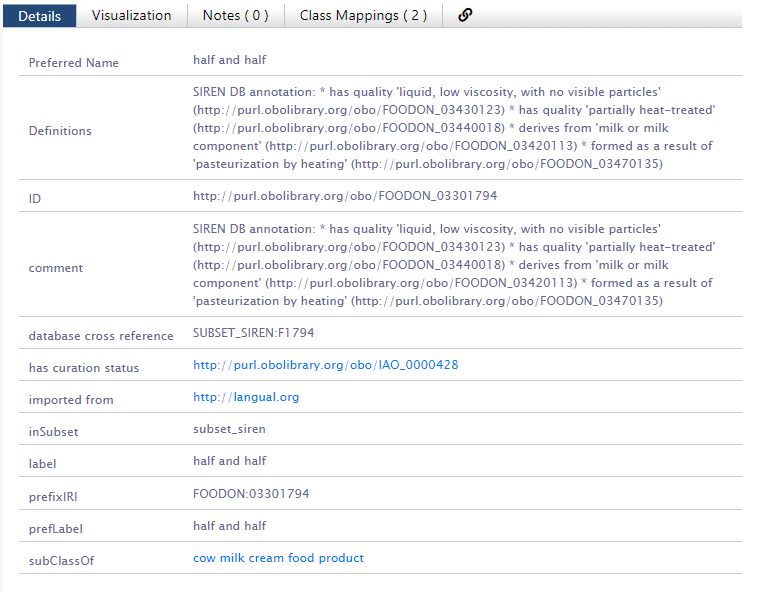

Class matched *full cream*

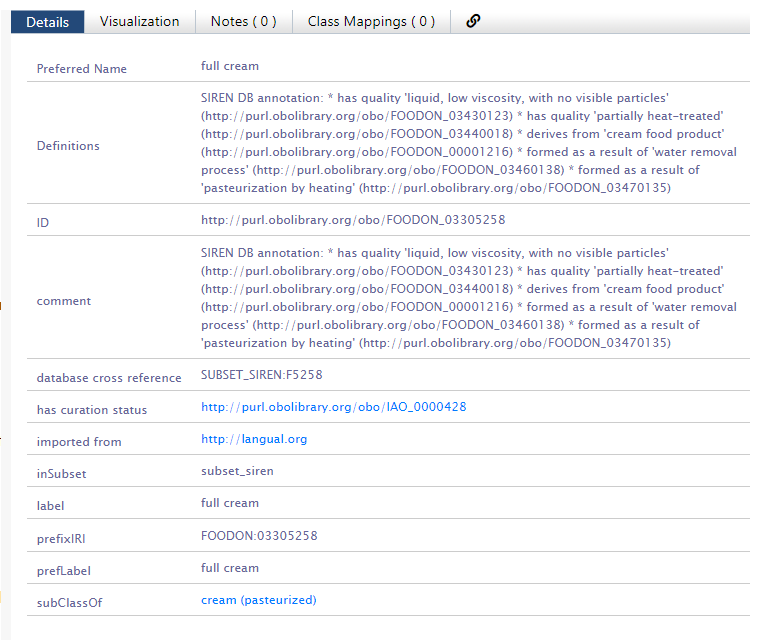

Class matched *soft*

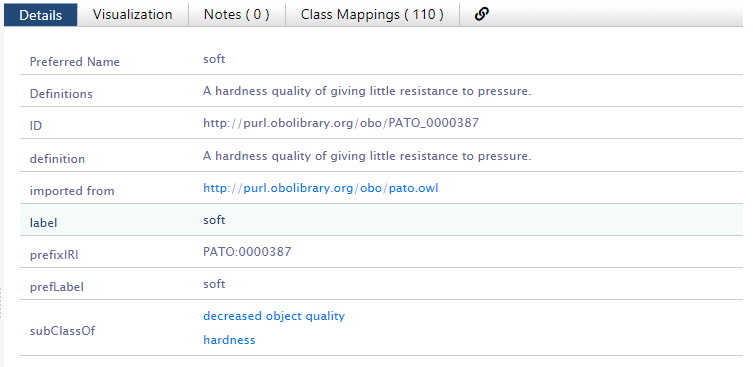

Class matched *whole grain*

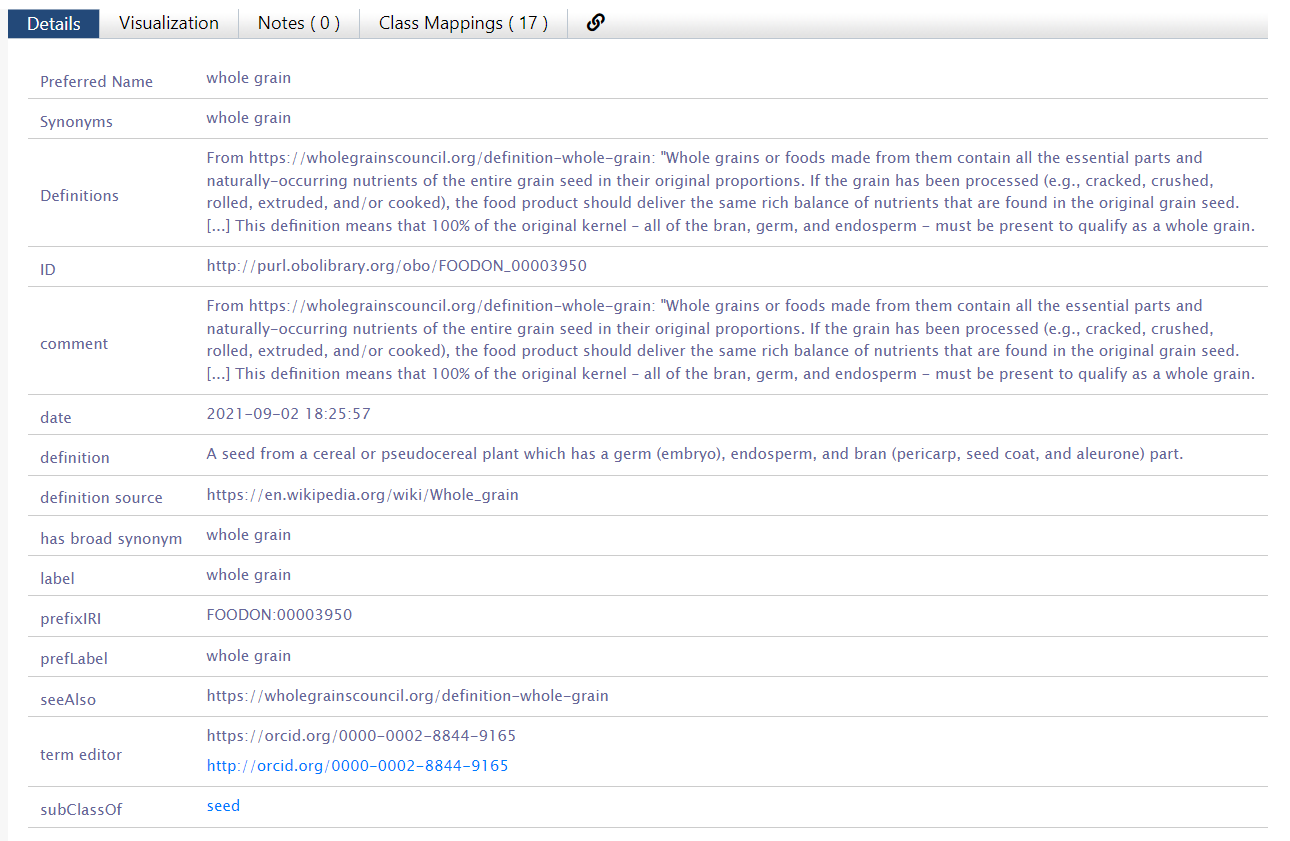

Class matched *plain*

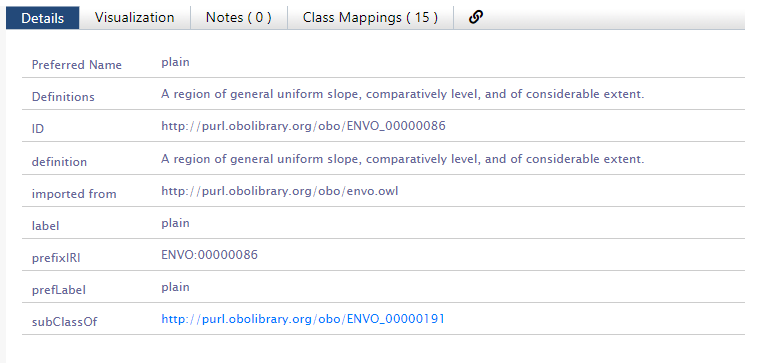

In [21]:
# OLDEST COUNTER BY CLASS 

counter_by_class = defaultdict(int)
manual_counter = defaultdict(int)

for ncbo_result in all_ncbo_results:
    for elem in ncbo_result:
        # TODO: czy to nie wynika z tego, że cinamon roll będzie w cinamon? - chyba nie...
        # TODO: może dodać enumerate i sprawdzac tylko w adnotacjach dla danego przepisu, a nie wszystkich, ale to było kłopotliwe...
        for key in elem:
            for manual_annotation in manual_annotations:
                if key in manual_annotation.keys():
                    counter_by_class[manual_annotation[key]] +=1
                    break
                    
for manual_annotation in manual_annotations:
    for key in manual_annotation.keys():
        manual_counter[manual_annotation[key]] +=1